In [1]:
pip install bitsandbytes -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.0 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login
login()

In [4]:
import torch
from transformers import  BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"  # nf4 = performant and stable
)
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.float16
)
import pandas as pd
train_df = pd.read_csv("mistake_identification_train.csv")
train_texts = (train_df["conversation_history"] + " " + train_df["response"]).tolist()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
import pandas as pd
import numpy as np
from collections import Counter

def generate_response(prompt, max_tokens=5):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("Label:")[-1].strip()

def generate_response_beam_reranked(prompt, max_tokens=5, num_beams=5):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)

    output = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=False,
        num_beams=num_beams,
        num_return_sequences=num_beams,
        return_dict_in_generate=True,
        output_scores=True,
        early_stopping=True
    )


    sequences = output.sequences
    decoded_outputs = [tokenizer.decode(seq, skip_special_tokens=True) for seq in sequences]

    completions = [
        x.split("Label:")[-1].strip() for x in decoded_outputs
    ]

    if output.scores is not None:
        log_probs = []
        for i in range(num_beams):
            seq_log_prob = sum([score[i].max().item() for score in output.scores])
            log_probs.append(seq_log_prob)

        best_index = int(np.argmax(log_probs))
        return completions[best_index]

    return completions[0]


In [ ]:
from tqdm import tqdm
val_df = pd.read_csv("mistake_identification_val.csv")

y_true = []
y_pred = []

for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
    student = row["last_student_turn"]
    response = row["response"]
    label = row["mistake_identification"]

    zeroshot_prompt = f"""### Task:
        You are an expert tutor evaluator. Label whether the tutor identifies the student's mistake.
        There are 3 possible labels:
        - Yes
        - To some extent
        - No
        Provide only the label.

        ### Student: {student}
        ### Tutor: {response}
        ### Label:"""

    pred = generate_response(zeroshot_prompt)

    y_true.append(label)
    y_pred.append(pred)

import re

def extract_label(text):
    text = text.strip().lower()
    if "yes" in text:
        return "Yes"
    elif "no" in text:
        return "No"
    elif "to some extent" in text:
        return "To some extent"
    return None


y_pred_cleaned = [extract_label(p) for p in y_pred]

 40%|███▉      | 195/493 [00:57<01:29,  3.33it/s]

In [7]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

def clean_and_score(y_true, y_pred_raw):
    valid_labels = {"Yes", "No", "To some extent"}
    y_pred_labels = []
    y_true_labels = []

    for yt, yp in zip(y_true, y_pred_raw):
        if yp in valid_labels:
            y_pred_labels.append(yp)
            yt_text = yt if isinstance(yt, str) else {0: "No", 1: "To some extent", 2: "Yes"}.get(yt)
            y_true_labels.append(yt_text)
        else:
            continue

    print(f"Evaluated {len(y_pred_labels)} / {len(y_true)} examples")
    df_preds = pd.DataFrame({
        "true_label": y_true_labels,
        "predicted_label": y_pred_labels
    })

    df_preds.to_csv("y_pred_mistral_baseline.csv", index=False)

    report = classification_report(
        y_true_labels,
        y_pred_labels,
        digits=3,
        zero_division=0
    )

    return report
report = clean_and_score(y_true, y_pred_cleaned)
print(report)

Evaluated 493 / 493 examples
                precision    recall  f1-score   support

            No      0.541     0.274     0.364        73
To some extent      0.097     0.484     0.162        31
           Yes      0.838     0.650     0.732       389

      accuracy                          0.584       493
     macro avg      0.492     0.469     0.419       493
  weighted avg      0.747     0.584     0.642       493



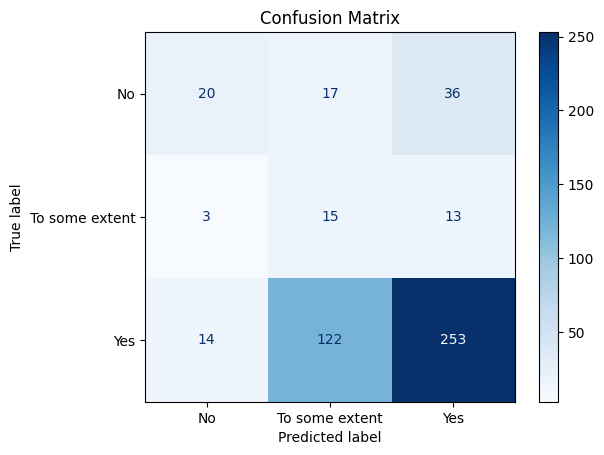

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label_map = {"No": 0, "To some extent": 1, "Yes": 2}
label_names = ["No", "To some extent", "Yes"]

y_pred_mapped = [label_map[label] for label in y_pred_cleaned]
cm = confusion_matrix(y_true, y_pred_mapped, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
